## Purpose of this document

This document aims to offer an alternative method for distinguishing between lung adenocarcinoma (LUAD) and lung squamous cell carcinoma (LUSC) through Convolutional Neural Networks (CNNs). Additionally, it incorporates interpretability aspects to discern the crucial features that the CNN leverages in the classification process.

### Summary

This document covers the following key sections:

<div class="lev1 toc-item"><a href="#Part-1.-Reading-and-Preprocessing-the-data" data-toc-modified-id="Part-1.-Reading-and-Preprocessing-the-data"><span class="toc-item-num"></span>Part 1. Reading and Preprocessing the data</a></div>
<div class="lev1 toc-item"><a href="#Part-2.-Splitting-the-dataset-into-training,-validation,-and-testing-set" data-toc-modified-id="Part-2.-Splitting-the-dataset-into-training,-validation,-and-testing-set"><span class="toc-item-num"></span>Part 2. Splitting the Dataset into Training, Validation, and Testing Set</a></div>
<div class="lev1 toc-item"><a href="#Part-3.-Build-and-Running-the-model" data-toc-modified-id="Part-3.-Build-and-Running-the-model"><span class="toc-item-num"></span>Part 3. Building and Running the Model</a></div>
<div class="lev1 toc-item"><a href="#Part-4.-Evaluating-the-models" data-toc-modified-id="Part-4.-Evaluating-the-models"><span class="toc-item-num"></span>Part 4. Evaluating the Models</a></div>
<div class="lev1 toc-item"><a href="#Part-5.-Interpretability-of-the-Models" data-toc-modified-id="Part-5.-Interpretability-of-the-Models"><span class="toc-item-num"></span>Part 5. Interpretability of the Models</a></div>

<div class="lev1 toc-item"><a href="#Part-6.-Future-Directions" data-toc-modified-id="Part-6.-Future-Directions"><span class="toc-item-num"></span>Part 6. Future Directions</a></div>

### Importing packages


Incorporating all the required packages for running the model, I opt for using TensorFlow over PyTorch due to its coding simplicity.

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

Verifying the availability and usage of GPU by TensorFlow

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [6]:
from tensorflow.python.client import device_lib

print("Available GPUs:", len(tf.config.experimental.list_physical_devices('GPU')))

print("Current device:", tf.test.gpu_device_name())

print("All devices:")
print(device_lib.list_local_devices())

tf.keras.backend.clear_session()

Available GPUs: 1
Current device: /device:GPU:0
All devices:
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8396435389871239540
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4139778048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3431011683036125455
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


<h3>Part 1. Reading and Preprocessing the data</h3>

Setting the directories and the paths in my system

In [8]:
data_dir = "C://Users//kaueu//Desktop//LC2500_filtered//lung_image_sets"
luscs_path = os.path.join(data_dir, "LUSC")
luad_path = os.path.join(data_dir, "LUAD")

Printing the variables to ensure the paths are correct.

In [9]:
print(luscs_path+' ',luad_path)

C://Users//kaueu//Desktop//LC2500_filtered//lung_image_sets\LUSC  C://Users//kaueu//Desktop//LC2500_filtered//lung_image_sets\LUAD


Defining a loading function to simplify image reading

In [10]:
def load_images_labels_paths(folder_path, label):
    images = []
    labels = []
    paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpeg"):
            img_path = os.path.join(folder_path, filename)
            paths.append(filename)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return paths, images, labels

Applying the function to extract attributes for both image classes, with 0 representing LUSC and 1 representing LUAD.

In [11]:
luscs_paths, luscs_images, luscs_labels = load_images_labels_paths(luscs_path, 0)
luad_paths,  luad_images, luad_labels = load_images_labels_paths(luad_path, 1)



Let's examine the types of processing required for the images.

In [12]:
X = np.array(luscs_images + luad_images)
y = np.array(luscs_labels + luad_labels)
paths = np.array(luscs_paths + luad_paths)

Checking array shape for consistency

In [14]:
print(X.shape)
print(y.shape)

(10000, 224, 224, 3)
(10000,)


(10000,)


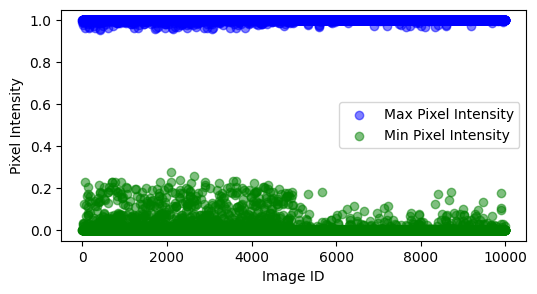

In [26]:
image_ids = np.arange(len(X))

# Calculate the maximum and minimum pixel values for each image
plt.figure(figsize=(6,3))
max_pixel_values = np.max(X, axis=(1, 2, 3))  # Assuming X has shape (num_images, 224, 224, 3)
min_pixel_values = np.min(X, axis=(1, 2, 3))
print(max_pixel_values.shape)
# Create a scatter plot
plt.scatter(image_ids, max_pixel_values, color='blue', label='Max Pixel Intensity',alpha=0.5)
plt.scatter(image_ids, min_pixel_values, color='green', label='Min Pixel Intensity',alpha=0.5)

# Add labels and legend
plt.xlabel('Image ID')
plt.ylabel('Pixel Intensity')
plt.legend()

# Show the plot
plt.show()

So far, we've observed certain characteristics of the data:

    1. The images share the same dimensions, eliminating the need for resizing.
    2. The pixel intensity values in the images show distinct ranges, thus normalization is suggested. Two potential approaches are:
         a. Normalizing using (X - X_min) / (X_max-X_min)
         b. Opting for simplicity by dividing each pixel value by 255, considering the maximum value reaches 255. We'll proceed with this approach.

In [21]:
X = X/255


Saving the variables in the system to enable skipping the previous steps in the future.

In [9]:
np.save('X',X)
np.save('y',y)
np.save('paths',paths)

#### If the variables have been previously saved, start the notebook from this point.

In [5]:
X = np.load('X.npy')
y = np.load('y.npy')
paths = nnp.load('paths.npy')


Creating plots to visually inspect the images.

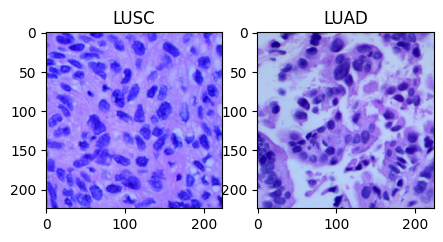

In [24]:
plt.figure(figsize=(5, 3))

plt.subplot(1, 2, 1)
plt.imshow(X[16])
plt.title('LUSC') 

plt.subplot(1, 2, 2)
plt.imshow(X[5016])
plt.title('LUAD')  

plt.show()

### Part 2. Splitting the dataset into training, validation, and testing set

I adopted  a 5-fold cross-validation instead of a simple holdout to test the model. Stratifying the classeshelps to  ensurs equal distribution of classes in each set, with a split of 60% for training, 20% for validation, and 20% for testing.In the end, the combination of the five test sets will compose the original dataset.

Splitting the  indices, as opposed to using the X data directly, is chosen for ease of access and storage limitation..

In [29]:
indices = np.arange(len(X))

num_folds = 5

skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(skf.split(X,y)):
    train_indices, val_indices = train_test_split(train_index, test_size=0.25, random_state=42, stratify=y[train_index])
    test_indices = test_index
    
    print(f"Fold {fold + 1}:")
    print("Training size:", len(train_indices))
    print("Check Class Balance:"+ str(np.sum(y[train_indices]))+' - '+str(len(train_indices) - np.sum(y[train_indices])))
    print("Validation size:", len(val_indices))
    print("Check Class Balance:"+ str(np.sum(y[val_indices]))+' - '+str(len(val_indices) - np.sum(y[val_indices])))
    print("Testing size:", len(test_indices))
    print("Check Class Balance:"+ str(np.sum(y[test_indices]))+' - '+str(len(val_indices) - np.sum(y[val_indices])))
    print("---")
    
    np.save('indices/train_indices_fold'+str(fold+1),train_indices)
    np.save('indices/val_indices_fold'+str(fold+1),val_indices)
    np.save('indices/test_indices_fold'+str(fold+1),test_indices)

Fold 1:
Training size: 6000
Check Class Balance:3000 - 3000
Validation size: 2000
Check Class Balance:1000 - 1000
Testing size: 2000
Check Class Balance:1000 - 1000
---
Fold 2:
Training size: 6000
Check Class Balance:3000 - 3000
Validation size: 2000
Check Class Balance:1000 - 1000
Testing size: 2000
Check Class Balance:1000 - 1000
---
Fold 3:
Training size: 6000
Check Class Balance:3000 - 3000
Validation size: 2000
Check Class Balance:1000 - 1000
Testing size: 2000
Check Class Balance:1000 - 1000
---
Fold 4:
Training size: 6000
Check Class Balance:3000 - 3000
Validation size: 2000
Check Class Balance:1000 - 1000
Testing size: 2000
Check Class Balance:1000 - 1000
---
Fold 5:
Training size: 6000
Check Class Balance:3000 - 3000
Validation size: 2000
Check Class Balance:1000 - 1000
Testing size: 2000
Check Class Balance:1000 - 1000
---


### Part 3. Build and Running the model

From now on, I will show the steps for a basic training (less images). Due to memory limitations on my local computer, I transferred the processing to a cluster to train the actual model. The code below precisely mirrors the content of the **run_training.py** script located in the main folder. The **gpu_batch.sh** file serves as the Slurm script, invoking **run_training.py** to execute the training process..

Pick the fold you want to work on:

In [31]:
fold=1

In [33]:
train_indices = np.load('indices/train_indices_fold'+str(fold)+'.npy') 
val_indices   = np.load('indices/val_indices_fold'+str(fold)+'.npy') 
test_indices  = np.load('indices/test_indices_fold'+str(fold)+'.npy') 

I decided to keep the model as simple as possible, increasing complexity only if needed (underfitting situation).

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

For the models, I added two callback functions.

    1. Only store the models with the lowest validation loss
    2. Reduce the learning rate if the model gets stuck after 4 epochs

In [ ]:
checkpoint_filepath = f"models/model_fold{fold}.h5"
model_checkpoint = ModelCheckpoint(checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=1e-6, verbose=1)

In [9]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       295168    
                                                                 
 flatten (Flatten)           (None, 692224)            0

In [11]:
history = model.fit(X[train_indices], 
                    y[train_indices],
                    epochs=10, 
                    batch_size=2, 
                    validation_data=(X[val_indices], y[val_indices]),
                    callbacks=[model_checkpoint, reduce_lr]
                   )

Epoch 1/10
70/70 [==============================] - 9s 58ms/step - loss: 1.2021 - accuracy: 0.4643 - val_loss: 0.6847 - val_accuracy: 0.5250
Epoch 2/10
70/70 [==============================] - 4s 56ms/step - loss: 0.6751 - accuracy: 0.6357 - val_loss: 0.8730 - val_accuracy: 0.5000
Epoch 3/10
70/70 [==============================] - 4s 56ms/step - loss: 0.6178 - accuracy: 0.6786 - val_loss: 0.8279 - val_accuracy: 0.5500
Epoch 4/10
70/70 [==============================] - 4s 56ms/step - loss: 0.3842 - accuracy: 0.8571 - val_loss: 0.6807 - val_accuracy: 0.7000
Epoch 5/10
70/70 [==============================] - 4s 56ms/step - loss: 0.2361 - accuracy: 0.9214 - val_loss: 0.4518 - val_accuracy: 0.8000
Epoch 6/10
70/70 [==============================] - 4s 56ms/step - loss: 0.2056 - accuracy: 0.9357 - val_loss: 0.5347 - val_accuracy: 0.7750
Epoch 7/10
70/70 [==============================] - 4s 56ms/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.5540 - val_accuracy: 0.7750
Epoch 8/10
70

### Part 4. Evaluating the models

In this section, I will describe first the simple execution of the model. And after the real execution and results of each individual fold. 
Again, due to memory constraints, I had to run the complete model in a cluster.

#### Showing Training curves

a. Accuracy level (Simple run)

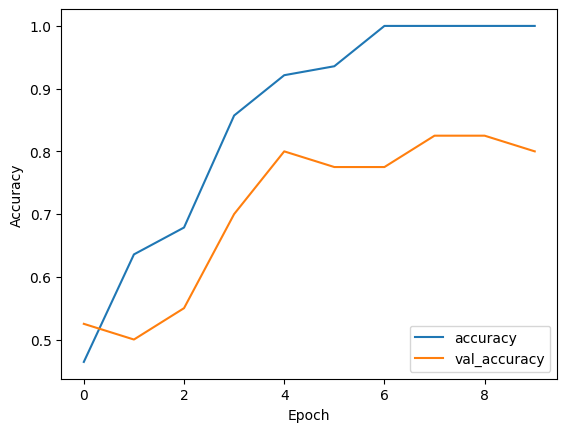

In [12]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

b. Accuracy level (Complete Run)

The models were saved in the lowest validation loss epoch

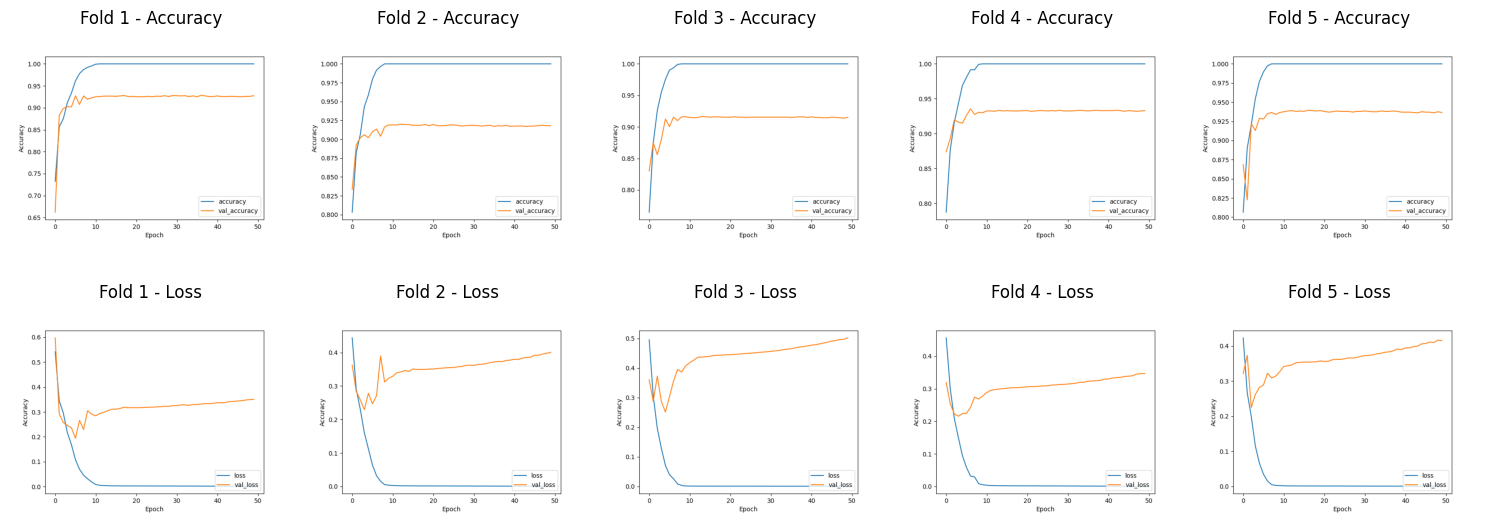

In [41]:
from matplotlib.image import imread
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

for fold in range(1, 6):
    acc_img_path = f'evaluation_metric/acc_{fold}.png'
    acc_img = imread(acc_img_path)
    axs[0, fold-1].imshow(acc_img)
    axs[0, fold-1].set_title(f'Fold {fold} - Accuracy')
    axs[0, fold-1].axis('off') 
    
    loss_img_path = f'evaluation_metric/loss_{fold}.png'
    loss_img = imread(loss_img_path)
    axs[1, fold-1].imshow(loss_img)
    axs[1, fold-1].set_title(f'Fold {fold} - Loss')
    axs[1, fold-1].axis('off') 

plt.tight_layout()
plt.show()

Predicting the output for the test_set

In [14]:
y_pred = model.predict(X[test_indices])
y_pred_binary = (y_pred > 0.5).astype(int)

#### Calculating accuracy and the confusion matrix

a. Accuracy and Confusion Matrix (Simple model)

In [16]:
accuracy = accuracy_score(y[test_indices], y_pred_binary)
conf_matrix = confusion_matrix(y[test_indices], y_pred_binary)

In [17]:
print(accuracy)

0.8


In [19]:
print(conf_matrix)

[[9 1]
 [3 7]]


b. Accuracy and Confusion Matrix (Complete model).

Be aware I'm just printing the values, but they can be checked in the folder slurms, in the end of the file.

| Fold    | 1 | 2  | 3 | 4 | 5 |
|---------|---|----|---|---|---|
|Accuracy         | 0.929 |0.919 |0.923 |0.916 |0.918 | 
|Confusion Matrix | $$\begin{bmatrix} 924 & 76 \\ 66 & 934 \end{bmatrix}$$ | $$\begin{bmatrix} 929 & 71 \\ 91 & 909 \end{bmatrix}$$|$$\begin{bmatrix} 925 & 75 \\ 78 & 922 \end{bmatrix}$$ | $$\begin{bmatrix} 962 & 38 \\ 130 & 870 \end{bmatrix}$$|$$\begin{bmatrix} 921 & 79 \\ 86 & 914 \end{bmatrix}$$| 


#### Calculating ROC curve

a. ROC curve (Simple model)

In [21]:
fpr, tpr, _ = roc_curve(y[test_indices], y_pred)
roc_auc = auc(fpr, tpr)

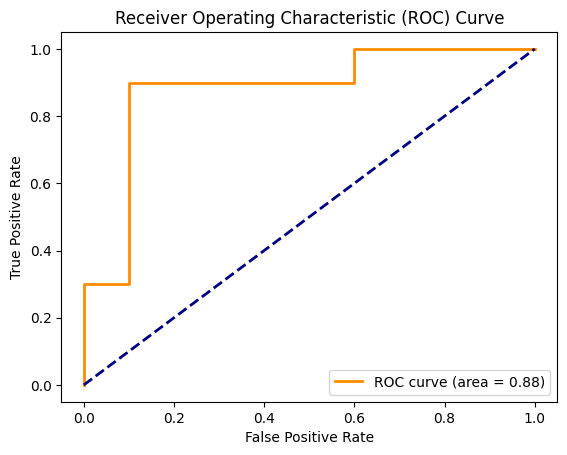

In [22]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

b. ROC curve (Complete model)

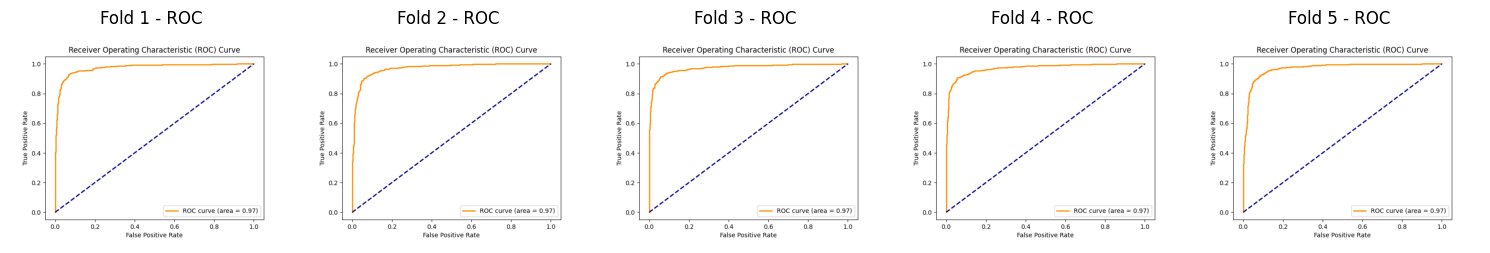

In [49]:
fig, axs = plt.subplots(1, 5, figsize=(15, 6))


for fold in range(1, 6):
    roc_img_path = f'evaluation_metric/roc_{fold}.png'
    roc_img = imread(roc_img_path)
    axs[fold-1].imshow(roc_img)
    axs[fold-1].set_title(f'Fold {fold} - ROC')
    axs[fold-1].axis('off') 
plt.tight_layout()
plt.show()

### Part 5. Interpretability of the Models

I ran a GradCam analysis in each model, generating plots for every sample to discern the areas deemed significant by the model. This analysis provided a clear understanding of the reason behin each image classification in different pathologies. 

All the gradcam images have been saved in the **GradCam** folder, maintaining the same names as those in the original dataset. For clarify, the right part of each plot displays  [prediction probability of the model] - actual class from the dataset. Please consider prediction_probability < 0.5 as False, and True if prediction_probability >= 0.5


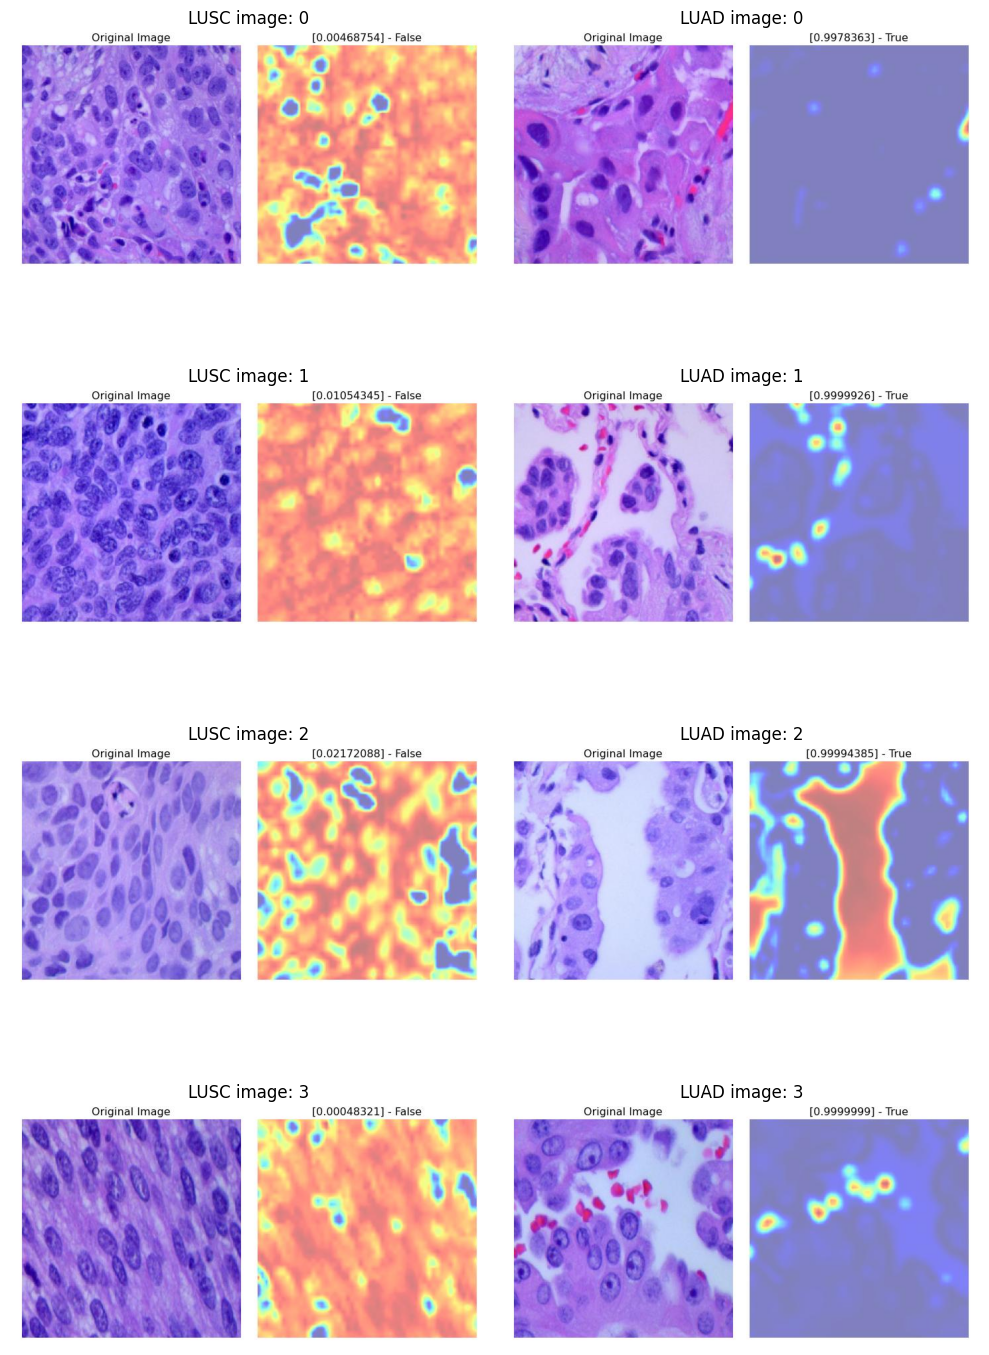

In [54]:

images_LUSC = ['lungscc869.jpeg','lungscc1013.jpeg','lungscc1080.jpeg','lungscc1141.jpeg']
images_LUAD = ['lungaca1.jpeg','lungaca4.jpeg','lungaca81.jpeg','lungaca83.jpeg']

fig, axs = plt.subplots(4, 2, figsize=(10, 15))

for i in range(4):
    lusc = 'GradCam/'+images_LUSC[i]
    lusc = imread(lusc)
    axs[i, 0].imshow(lusc)
    axs[i, 0].set_title(f'LUSC image: {i}')
    axs[i, 0].axis('off') 
    
    luad = 'GradCam/'+images_LUAD[i]
    luad = imread(luad)
    axs[i, 1].imshow(luad)
    axs[i, 1].set_title(f'LUAD image: {i}')
    axs[i, 1].axis('off') 

plt.tight_layout()
plt.show()

Acknowledging that my expertise lies in interpreting image patterns rather than histological types of lung cancer, I've observed certain patterns in the data:

    1. LUAD images often exhibit a substantial number of red dots or an extensive white area.
    2. In instances where LUAD images contain both red dots and a large white area, the model tends to prioritize red blobs for classifying as LUAD. This preference is likely influenced by the consistent presence of red dots in LUAD samples.
    3. LUSC images, on the other hand, seem to rely more on the entire background for classifying the sample.

It's crucial to approach any histological interpretation with caution, as my analysis is solely based on image patterns. For a more accurate interpretation, please consult and oncologist.

### Part 6. Future Directions

Some possible directions that can be consider after the execution of this work are:

    1. Transfer Learning: Using pretrained weights from different image domains could enhance the accuracy of the models.
    2. Data augmentation: Employing tools like MONAI to introduce variations in the input data may improve the generalizability of the model.
    3. New architectures: Exploring more complex architectures beyond the simple one used in this study. It's important to note that complexity doesn't always guarantee better predictions.
    4. Adjusting Architecture Depth and Parameters: Fine-tuning the existing architecture by experimenting with depth, number of parameters, and introducing elements like dropouts, batch normalization, or additional convolutional layers.
    5. Transformers-like approaches: Considering alternative classification techniques, such as approaches inspired by transformers, as CNNs may not always give the highest accuracies.


In general, I enjoyed working with these images. The dataset is well-organized and easy to manage.

I hope this document was easy to understand. Please reach out to kaue.unicamp2011@gmail.com if you have any questions